In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Bayesian Models

# 1. Fitting models & working with multiple observations

In demographic studies of extragalactic stellar sources, often we describe the populations as a function of host galaxy properties. This is a way to study  *ultraluminous X-ray sources* which are predominantly young X-ray binaries where a compact object (neutron star or black hole) accretes matter from the companion (a main-sequence or evolved star) at super-Eddington rates. Because of their short lifetimes, they are found in galaxies that are forming new stars intensly, namely, with high star-formation rate. Let's see if how we can fit the scaling factor between the star-formation rate and the number of ULXs:

$$\Large N_{\text{ULX}} = a \frac{\text{SFR}}{1\rm\,M_\odot\,yr^{-1}} $$

# Let's make some data...

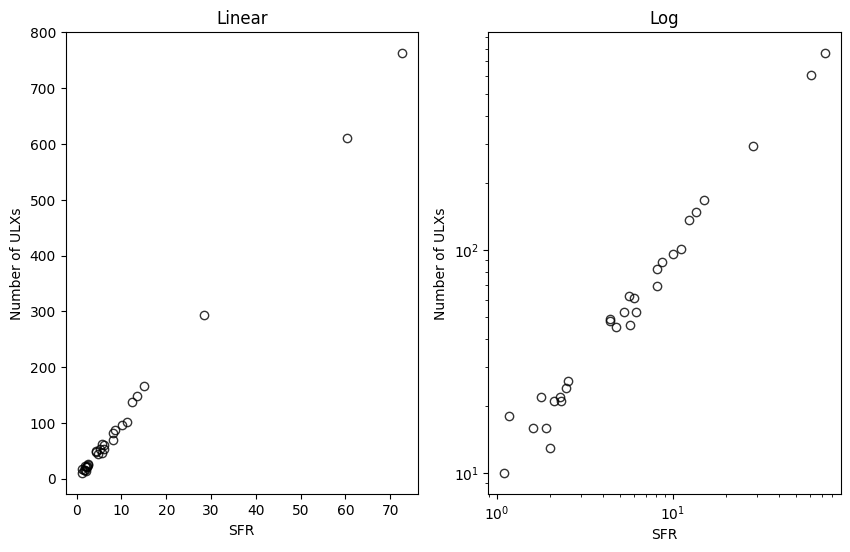

In [47]:
import numpy as np
import matplotlib.pyplot as plt

n_galaxies = 30
a_true = 10          # change with 0.5... what is the problem with the fit in log-space?

# make the x and y values
np.random.seed(2023)
SFRs = 10.0 ** np.random.uniform(0, 2.0, size=n_galaxies)
n_ULXs = np.random.poisson(a_true * SFRs)

plt.figure(figsize=(10, 6))
for inlog, subplot, subplot_title in zip([False, True], [1, 2], ["Linear", "Log"]):
    plt.subplot(1, 2, subplot)
    plt.title(subplot_title)
    plt.plot(SFRs, n_ULXs, "ko", mfc="None", alpha=0.8)
    plt.xlabel("SFR")
    plt.ylabel("Number of ULXs")
    if inlog:
        plt.loglog()
plt.show()

# How to fit for $a$?

Approach 1: Use the least-squares fit to estimate a slope and intercept.

In [3]:
slope, interc = np.polyfit(x=SFRs, y=n_ULXs, deg=1)

print(f"Least-squares fit: y = {slope:.4g} x {'-' if interc < 0 else '+'} {abs(interc):.4g}")

Least-squares fit: y = 10.38 x - 2.043


## What is the problem with fitting in linear space?

Approach 2: Fit in log-space.

In [4]:
slope_log, interc_log = np.polyfit(x=np.log10(SFRs), y=np.log10(n_ULXs), deg=1)
print(f"Fitting in log space: y = {10.0**interc_log:.4g} x ^ {slope_log:.4g}")

Fitting in log space: y = 9.75 x ^ 1.01


## What is the problem with fitting in log space?

Approach 3: Use the model proposed by the theory. Let $s_i$ and $n_i$ be the star-formation rate and number of ULXs in each galaxy in the sample. Using the fact that the a number of sources is Poisson-distributed, we estimate $a$ using Maximum Likelihood Estimation:

$$\large L = \prod_{i=1}^{N} P(s_i, n_i | a) = \prod_{i=1}^{N} \mathrm{Pois}(n_i; a s_i) = \prod_{i=1}^{N} \dfrac{(a s_i)^{n_i} e^{-a s_i}}{n_i!}$$

$$ \large l = \ln L = \sum\limits_{i=1}^{N} \ln \dfrac{(a s_i)^{n_i} e^{-a s_i}}{n_i!} = \sum\limits_{i=1}^N \left[ n_i(\ln a + \ln s_i) - a s_i - \ln n! \right] $$

$$ \large \dfrac{\partial \ln l}{\partial a} = 0 \Rightarrow \sum\limits_{i=1}^N \left(n_i \dfrac{1}{a} - s_i \right) = 0 \Rightarrow \dfrac{1}{a} \sum\limits_{i=1}^N n_i - \sum\limits_{i=1}^N s_i = 0$$

$$\large a = \dfrac{\sum\limits_{i=1}^{N} n_i}{\sum\limits_{i=1}^{N} s_i}$$

## Is this intuitive?

Since our values are independent, summing up all numbers of ULXs, is a new Poisson distributed variable. This is as if we took all the galaxies and merged them instantaniously into a new galaxy. The star-formation rate of this new humongous galaxies is going to be the total SFR in our sample! The propotionality constant between the two numbers is the desired parameter $a$ since ULXs do not care about their host galaxy... they are naturally spawn through the star-formation process.

The MLE estimate: y = 10.19
Least-squares fit: y = 10.38 x - 2.043
Fitting in log space: y = 9.75 x ^ 1.01


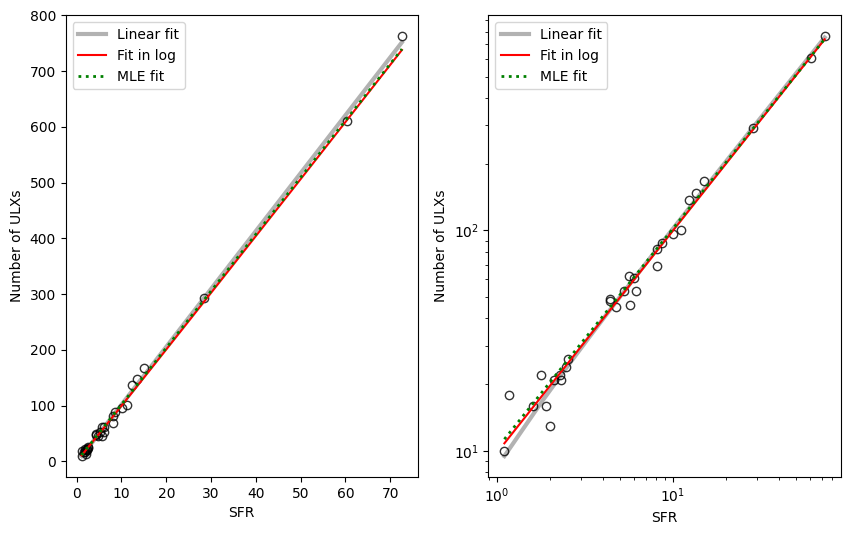

In [5]:
slope_mle = sum(n_ULXs) / sum(SFRs)
print(f"The MLE estimate: y = {slope_mle:.4g}")

print(f"Least-squares fit: y = {slope:.4g} x {'-' if interc < 0 else '+'} {abs(interc):.4g}")
print(f"Fitting in log space: y = {10.0**interc_log:.4g} x ^ {slope_log:.4g}")

xx = np.linspace(min(SFRs), max(SFRs), 100)
yy_lin = slope * xx + interc
yy_log = 10.0 ** (slope_log * np.log10(xx) + interc_log)
yy_mle = slope_mle * xx

sign = "+" if interc >= 0 else "-"

plt.figure(figsize=(10, 6))
for inlog, subplot in zip([False, True], [1, 2]):
    plt.subplot(1, 2, subplot)
    plt.plot(SFRs, n_ULXs, "ko", mfc="None", alpha=0.8)
    plt.plot(xx, yy_lin, "k-", lw=3, alpha=0.3, label="Linear fit")
    plt.plot(xx, yy_log, "r-", label="Fit in log")
    plt.plot(xx, yy_mle, "g:", lw=2, label="MLE fit")
    plt.xlabel("SFR")
    plt.ylabel("Number of ULXs")
    if inlog:
        plt.loglog()
    plt.legend(loc="upper left")
plt.show()

# In Bayesian language

We have measurements of the number of ULXs, 
$$\large \{n_i\} = \{n_1, n_2, \cdots, n_N\}$$
and the star-formation rates 
$$\large \{s_i\} = \{s_1, s_2, \cdots, s_N\}$$
for $N$ galaxies.

We expect them to scale with $a$ as the scaling factor and we want to find its value. 

$$\large n_i \approx a s_i $$

However, it is not an equality because in reality, the number of XRBs is Poisson-distributed. The expression could only connect the average number of XRBs in a galaxy as a function of its SFR. The observed value is just following this distribution (if our model is correct):

$$\large n_i \sim \text{Pois}(a s_i) $$

Then the posterior of the scaling factor is:

$$\large 
\begin{align}
        & P(\text{parameters} | \text{data}) = &\quad\text{(for our problem...)}
    \\ =& P(a | \{n_i\} \{s_i\}) = &\quad \text{(apply Bayes' formula)}
    \\ =& P(\{n_i\} | a, \{s_i\}) P(a) = &\quad \text{(break it down to all data/param.)}
    \\ =& P(n_1, n_2, n_3, \cdots n_N | a, s_1, s_2, s_3, \cdots s_N) P(a) &\quad \text{(assume independent data)}
    \\ =& \left[P(n_1 | a, s_1, s_2, s_3, \cdots s_N) \times P(n_2 | a, s_1, s_2, s_3, \cdots s_N) \cdots \right] P(a) = &\quad\text{(but $n_{i\neq j}$ doesn't depend on $s_j$)}
    \\ =& \left[P(n_1 | a, s_1) \times P(n_2 | a, s_2) \cdots P(n_N | a, s_N) \right] P(a) = &\quad\text{(a product of likelihoods...)}
    \\ =& P(a) \prod_{i=1}^{N} P(n_i | a, s_i) = P(a) \prod_{i=1}^{N} L_i
\end{align}
$$

where 

$$\large
L_i = P(n_i | a, s_i)
$$

is the $i$-th **datum likelihood**: the likelihood of the $i$-th datapoint given the value of the parameter. Datum likelihoods are only useful (as shortcuts) if the datapoints are independent. Usually, when people write down their Bayesian analysis, they often take this for granted and start directly from the above equation for the posterior.

Therefore, for our problem we can simply state:

$$\large P(a | \{n_i\} \{s_i\}) = P(a) \prod_{i=1}^{N} L_i $$

where $P(a)$ is the prior which we chose to be uniform, allowing only positive values for the scaling factor, and the datum likelihood is the PMF of the Poisson distribution with mean value equal to $a s_i$ evaluated at $n_i$:

$$\large
L_i = P(n_i | a, s_i) = \text{Pois}(n_i; a s_i) = \dfrac{(a s_i)^{n_i} e^{-a s_i}}{n_i!}
$$

In [6]:
import scipy.stats as st

def prior(scaling_factor):
    return 0.0 if scaling_factor < 0 else 1.0

def datum_likelihood(nulx, sfr, scaling_factor):
    return st.poisson.pmf(nulx, sfr * scaling_factor)

def likelihood(nulx_array, sfr_array, scaling_factor):
    return np.prod([datum_likelihood(nulx_i, sfr_i, scaling_factor) 
                    for nulx_i, sfr_i in zip(nulx_array, sfr_array)])

def posterior(scaling_factor, nulx_array, sfr_array):
    return likelihood(nulx_array, sfr_array, scaling_factor) * prior(scaling_factor)

a_values = np.linspace(a_true / 2.0, a_true * 2.0, 1000)
P_values = np.array([posterior(scaling_factor=a, nulx_array=n_ULXs, sfr_array=SFRs) for a in a_values])

# now try with 100 data points

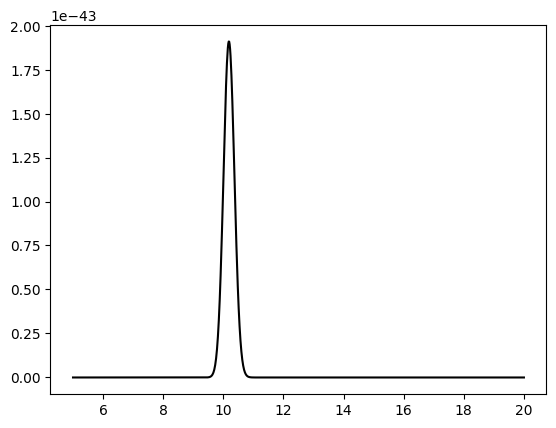

In [7]:
plt.figure()
plt.plot(a_values, P_values, "k-")
plt.show()

* Do the same computation, but this time change the `a_true` to 0.5. What is the problem?
* Do the same computation, but this time use 100 data points. What is the problem?
* What if we wanted to find the optimal value, i.e. where is the maximum of the posterior?

$$\large 
\frac{\partial}{\partial a} P(a | \{n_i\} \{s_i\}) = 0 
\Rightarrow 
\frac{\partial}{\partial a} P(a) \prod_{i=1}^{N} \dfrac{(a s_i)^{n_i} e^{-a s_i}}{n_i!} = 0 $$

# Working in log-space

When we are computing likelihoods and posteriors, we often explore regions where the model is improbable, and the quantities tend to zero. Also, with many data points, the product of the datum likelihoods becomes smaller and smaller, and often evaluates to zero!

In addition, differentiating the posterior (analytically or numerically) might be difficult if there is a significant peak.

Working in log-space alleviates all the above issues! The bell-like peaks become parbolas, the probabilities are now negative values with small absolute values. So the **log-posterior** is

$$\large
\ln \large P(a | \{n_i\} \{s_i\}) = \ln P(a) + \sum_{i=1}^{N} \ln L_i
$$

the sum of the **log-prior** and the **log-likelihood**, the latter being the sum of all **datum log-likelihoods**.

It's so useful, and more accurate to work in log-space, that most `scipy` statistical distributions have their log-analogs (e.g, `st.poisson.logpmf(...)`) that are optimized to give more accurate results than log-ing the original function.

Therefore, we can re-write the functions in their log-versions:

In [8]:
def ln_prior(scaling_factor):
    # return 0.0 if scaling_factor < 0 else 1.0
    return -np.inf if scaling_factor < 0 else 0.0

def datum_ln_likelihood(nulx, sfr, scaling_factor):
    # return st.poisson.pmf(nulx, sfr * scaling_factor)
    return st.poisson.logpmf(nulx, sfr * scaling_factor)

def ln_likelihood(nulx_array, sfr_array, scaling_factor):
    # return np.prod([datum_likelihood(nulx_i, sfr_i, scaling_factor) 
    #                for nulx_i, sfr_i in zip(nulx_array, sfr_array)])
    return np.sum([datum_ln_likelihood(nulx_i, sfr_i, scaling_factor)
                   for nulx_i, sfr_i in zip(nulx_array, sfr_array)])

def ln_posterior(scaling_factor):
    return ln_likelihood(n_ULXs, SFRs, scaling_factor) + ln_prior(scaling_factor)

lnP_values = np.array([ln_posterior(scaling_factor=a) for a in a_values])

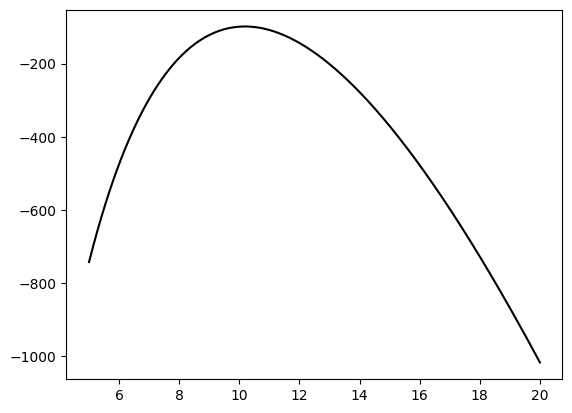

In [9]:
plt.figure()
plt.plot(a_values, lnP_values, "k-")
plt.show()

# Minimization as a means to get the Maximum a Posteriori (MAP) estimate

The parameter value at which the posterior is maximized is an estimate for the true value of the parameter. The maximum a posteriori estimate can be found using optimization techniques. Many algorithms have been implemented to do this for us (for example in the `scipy` package). Traditionally the search for the minimum in a function. Therefore, we proceed by negating the log-posterior. Let's try that!

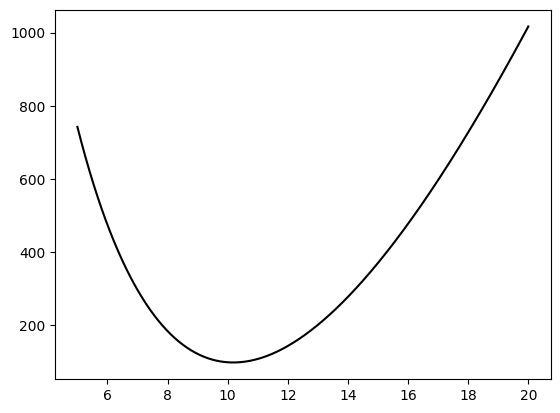

MAP estimate for a = 10.19


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 98.36382070656082
       x: [ 1.019e+01]
     nit: 9
     jac: [ 8.583e-06]
    nfev: 29
    njev: 9

In [10]:
from scipy.optimize import minimize

def neg_ln_posterior(scaling_factor):
    return -ln_posterior(scaling_factor)

plt.figure()
plt.plot(a_values, [neg_ln_posterior(ai) for ai in a_values], "k-")
plt.show()

# TNC, SLSQP, Powell, trust-constr
minimization_result = minimize(neg_ln_posterior,  x0=1.0, method="SLSQP", bounds=[[0.0, 20.0]], tol=1.0e-12)
print(f"MAP estimate for a = {minimization_result.x[0]:.4g}")
minimization_result

# Getting the uncertainty on the parameter using the shape of the posterior

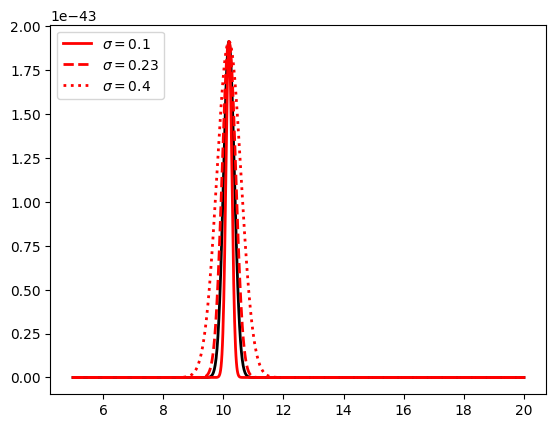

In [11]:
a_MAP = minimization_result.x[0]
P_at_a_MAP = posterior(a_MAP, nulx_array=n_ULXs, sfr_array=SFRs)
sigmas = [0.1, 0.23, 0.4]

plt.figure()
plt.plot(a_values, P_values, "k-", lw=2)
for sigma, ls in zip(sigmas, ["-", "--", ":"]):
    plt.plot(a_values, P_at_a_MAP * np.exp(-(a_values-a_MAP)**2.0 / (2*sigma**2.0)), "r", ls=ls, label=r"$\sigma=$"+f"{sigma:.3g}", lw=2)
plt.legend(loc="upper left")
plt.show()

/tmp/ipykernel_96931/2681497760.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(a_values, np.log(P_values), "k-", lw=2)


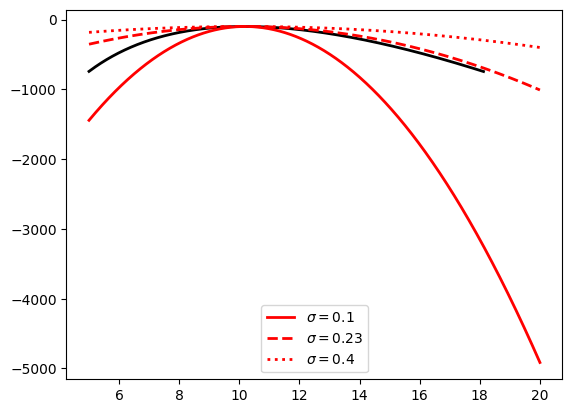

In [12]:
a_MAP = minimization_result.x[0]
lnP_at_a_MAP = ln_posterior(a_MAP)

plt.figure()
plt.plot(a_values, np.log(P_values), "k-", lw=2)
for sigma, ls in zip(sigmas, ["-", "--", ":"]):
    plt.plot(a_values, lnP_at_a_MAP - (a_values-a_MAP)**2.0 / (2*sigma**2.0), "r", ls=ls, label=r"$\sigma=$"+f"{sigma:.3g}", lw=2)
plt.legend(loc="lower center")
plt.show()

/tmp/ipykernel_96931/3815799964.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(a_values, np.log(P_values) - lnP_at_a_MAP, "k-", lw=2)


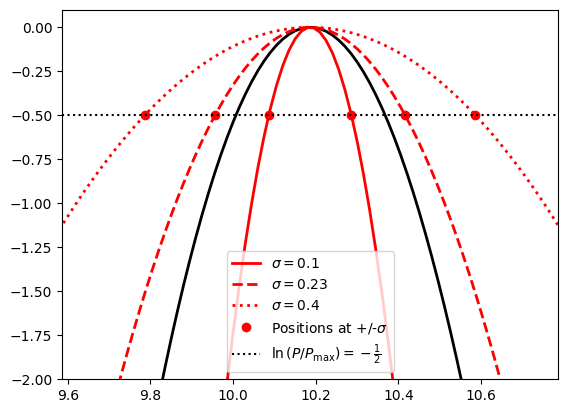

In [13]:
a_MAP = minimization_result.x[0]
lnP_at_a_MAP = ln_posterior(a_MAP)

plt.figure()
plt.plot(a_values, np.log(P_values) - lnP_at_a_MAP, "k-", lw=2)
for sigma, ls in zip(sigmas, ["-", "--", ":"]):
    plt.plot(a_values, -(a_values-a_MAP)**2.0 / (2*sigma**2.0), "r", ls=ls, label=r"$\sigma=$"+f"{sigma:.3g}", lw=2)
    for offset_in_sigmas in [-1, 1]:
        plt.plot(a_MAP + offset_in_sigmas * sigma, -(offset_in_sigmas * sigma)**2.0 / (2*sigma**2.0), "ro")
plt.plot([], [], "ro", label="Positions at +/-$\sigma$")
plt.axhline(-0.5, color="k", ls=":", label=r"$\ln\left(P / P_{\max}\right)=-\frac{1}{2}$")
plt.legend(loc="lower center")
plt.xlim(a_MAP - 0.6, a_MAP + 0.6)
plt.ylim(-2.0, 0.1)
plt.show()

MAP = 10.186 +/- 0.181 ... from the solutions: 10.007 and 10.368


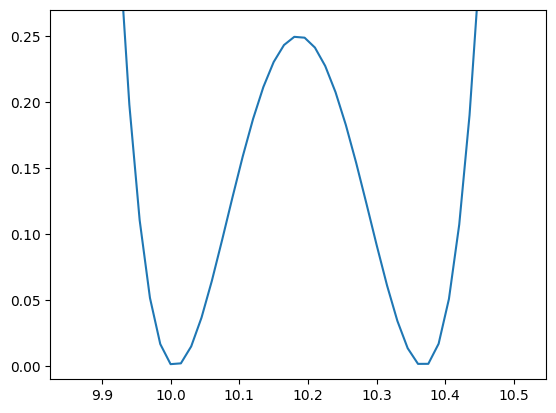

( message: Optimization terminated successfully
  success: True
   status: 0
      fun: 2.171576028836076e-07
        x: [ 1.001e+01]
      nit: 13
      jac: [ 5.219e-03]
     nfev: 27
     njev: 13,
  message: Optimization terminated successfully
  success: True
   status: 0
      fun: 2.411457499440396e-09
        x: [ 1.037e+01]
      nit: 18
      jac: [ 5.378e-04]
     nfev: 36
     njev: 18)

In [14]:
solution_left = minimize(lambda x: (ln_posterior(x) - lnP_at_a_MAP + 0.5)**2.0, x0=a_MAP / 2.0, method="SLSQP", bounds=[[0.0, a_MAP*0.999]])
solution_right = minimize(lambda x: (ln_posterior(x) - lnP_at_a_MAP + 0.5)**2.0, x0=a_MAP * 2.0, method="SLSQP", bounds=[[a_MAP*1.001, np.inf]])

a_lo = solution_left.x[0]
a_hi = solution_right.x[0]
a_err = (a_hi - a_lo) / 2.0
print(f"MAP = {a_MAP:.3f} +/- {a_err:.3f} ... from the solutions: {solution_left.x[0]:.3f} and {solution_right.x[0]:.3f}")

plt.figure()
xx = a_values
yy = [(ln_posterior(xxi) - lnP_at_a_MAP + 0.5)**2.0 for xxi in xx]
plt.plot(a_values, yy)
plt.xlim(a_MAP - 2*a_err, a_MAP + 2*a_err)
plt.ylim(-0.01, 0.27)
plt.show()

solution_left, solution_right

# Hypothesis Testing and Model Selection: Frequentism vs. Baysianism

> Science is more than a body of knowledge; it is a way of thinking.
> The method of science, as stodgy and grumpy as it may seem,
> is far more important than the findings of science. — Carl Sagan

## Fitting a spectral line

In astronomy, a lot of information about the physical and emission properties of astronomical objects is accessed through spectroscopic measurements, i.e., the emission intensity as a function of wavelength/frequency. Interesting spectral features are emission or absorption lines. Naturally, the lines are not... lines, but narrow peaks! A true line is impossible due to quantum effects, but in addition, local/extended effects tend to "broaden" or alter the shape of spectal lines (e.g., thermal doppler, pressure, rotation of object, 

$$\large 
\begin{align}
y(x) = \dfrac{A}{1 + \left(\dfrac{x - x_0}{w}\right)^2}           & \qquad \text{(Lorentzian or Cauchy model)} \\
y(x) = A \exp{\left[-\frac{\left(x - x_0\right)^2}{2 w^2}\right]} & \qquad \text{(Gaussian or Normal model)}
\end{align}
$$



Where 
* $A$ is the amplitude (notice that $y(x_0) = A$ in both cases), 
* $x_0$ is the location paramer (the center of the line), and
* $w$ is the "spread" or width of the line.


> Notice that here we use the word Cauchy and Gaussian to refer to non-linear models rather than distributions. Our data follows the shape of the PDFs of these distributions, not the distributions themselves!


Now, let's assume we have measured the intensitities $y_i$ at given (unitless) wavelengths $x_i$, and that the errors $e_i$ are normally distributed with standard deviation $\sigma$:

$$\large y_i = y(x_i) + \epsilon_i, \qquad \epsilon_i \sim \text{Norm}(0, \sigma)$$

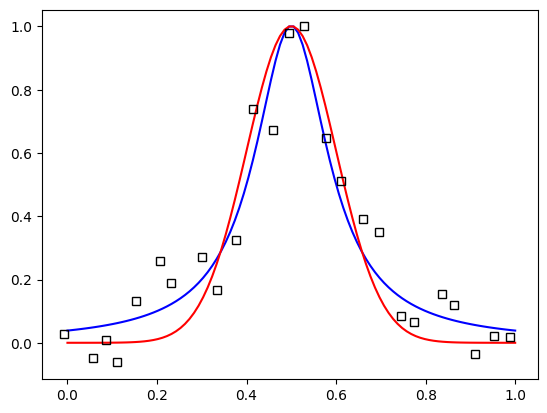

In [60]:
def make_data(x, model_dist, amplitude, location, width, error_scale=0.0):
    """Make a spectral line following the PDF of a given distribution.
    
    x           : the wavelength
    model_dist  : the distribution of which the PDF will be used
    amplitude   : the maximum height of the spectral line
    location    : the center of the spectral line
    width       : the width of the spectral line
    error_scale : the standard deviation of the observational uncertainties
    
    NOTE: use default `error_scale` (0.0) to get a model instead of observational sample.
    
    """
    distribution = model_dist(loc=location, scale=width)
    y = distribution.pdf(x)
    y *= amplitude / distribution.pdf(location)   # this only works for distributions symmetric around the location parameter - otherwise use/calculate the mode
    if error_scale > 0:
        y = np.random.normal(y, scale=error_scale)
    return y

np.random.seed(2023)

x_plot = np.linspace(0, 1, 100)
y1_plot = make_data(x_plot, st.cauchy, amplitude=1.0, location=0.5, width=0.1)
y2_plot = make_data(x_plot, st.norm, amplitude=1.0, location=0.5, width=0.1)

model_distributions = [st.cauchy, st.norm]

n_data = 25
true_model_distribution = model_distributions[31337 % 17 % 2]
x_data = np.linspace(0.0, 1.0, n_data) + np.random.uniform(-0.5/n_data, 0.5/n_data, size=n_data)
y_data = make_data(x_data, true_model_distribution, amplitude=1.0, location=0.5, width=0.1, error_scale=0.1)
y_data /= y_data.max()
y_data

plt.figure()
plt.plot(x_plot, y1_plot / y1_plot.max(), "b-")
plt.plot(x_plot, y2_plot / y2_plot.max(), "r-")
plt.plot(x_data, y_data, "ks", mfc="none")
plt.show()

# Which model fits best the data?

## The Likelihood Ratio

Given the Guassian uncertainties, the assuming independent measurements, we derive the following likelihood of a model $y = y(x)$:

$$\large L = \prod_i \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left[-\dfrac{\left(y_i - y(x_i)\right)^2}{2\sigma^2} \right]$$

$$\large L \propto \exp\left[-\frac{1}{2}\sum\limits_i \left(\dfrac{r_i}{\sigma}\right)^2 \right] \qquad \text{where} \qquad r_i = y_i - y(x_i) $$

$$\large l = \ln L = -\frac{1}{2}\sum\limits_i \left(\dfrac{r_i}{\sigma}\right)^2 + \text{constant}$$

When we have two models $A$ and $B$, the likelihood ratio is simply the ratio of the two likelihoods computed their respective $y(x)$:

$$ \large \mathrm{LR}_{AB} = \dfrac{L_A}{L_B} = \exp\left(l_A - l_B\right) $$

Notice that we use logarithms to avoid numerical issues (e.g., infinities, NaN values, etc. when many data or bad models).

WARNING: There is a different but closely-related quanitity called *Likelihood Ratio Test statistic*: $ \large \lambda_{AB} = -2 \left( l_A - l_B \right) $.

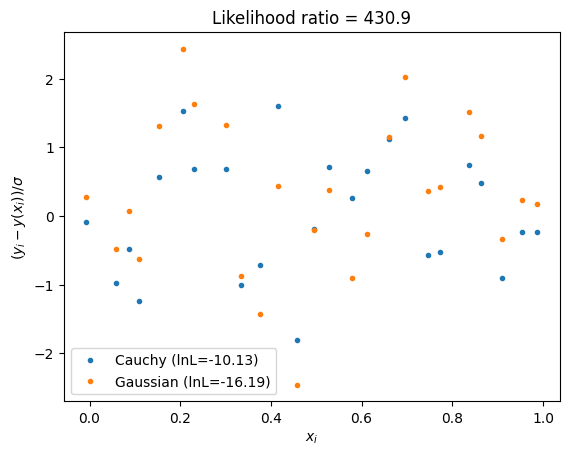

In [61]:
def log_likelihood(x_data, y_data, model_dist, amplitude, location, width, error_scale, plot=None):
    y_pred = make_data(x_data, model_dist=model_dist, amplitude=amplitude, location=location, width=width, error_scale=0.0)
    residuals = y_data - y_pred
    log_like = -0.5 * np.sum((residuals / error_scale)**2.0)
    
    if plot is not None:
        plt.plot(x_data, residuals / error_scale, ".", label=f"{plot} (lnL={log_like:.4g})")
    return log_like

plt.figure()

loglike1 = log_likelihood(x_data, y_data, st.cauchy, amplitude=1.0, location=0.5, width=0.1, error_scale=0.1, plot="Cauchy")
loglike2 = log_likelihood(x_data, y_data, st.norm, amplitude=1.0, location=0.5, width=0.1, error_scale=0.1, plot="Gaussian")
likelihood_ratio = np.exp(loglike1 - loglike2)

plt.xlabel("$x_i$")
plt.ylabel("$(y_i - y(x_i)) / \sigma$")
plt.legend(loc="best")
plt.title(f"Likelihood ratio = {likelihood_ratio:.4g}")
plt.show()

# The reduced chi-square statistic

In the likelihood above, the quantities

$$\large \left(\dfrac{r_i}{\sigma}\right)^2$$

are called *weight squared deviations*. Their sum is called a *chi square*:

$$\large \chi^2 = \sum\limits_i \left(\dfrac{r_i}{\sigma}\right)^2 $$

and can be generalized in the case where each data point has its own uncertainty:

$$\large \chi^2 = \sum\limits_i \left(\dfrac{y_i - y(x_i)}{s_i}\right)^2 $$

This **statistic** is called chi-square because when the residuals are normally distributed, it follows the $\chi^2$-distribution with parameter $k$ - the degrees of freedom, which is typically the number of data points.

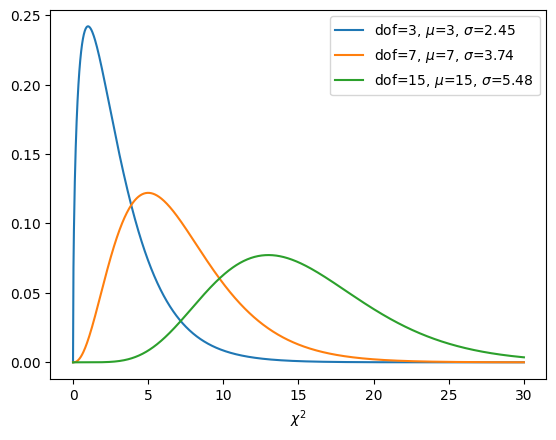

In [62]:
xx = np.linspace(0.0, 30.0, 1000)
plt.figure()
for dof in [3, 7, 15]:
    chi_dist = st.chi2(dof)
    plt.plot(xx, chi_dist.pdf(xx), "-", label=f"dof={dof}, $\mu$={chi_dist.mean():.3g}, $\sigma$={chi_dist.std():.3g}")
plt.xlabel("$\chi^2$")
plt.legend(loc="upper right")
plt.show()

Therefore, if we have the correct model, and the uncertainties are indeed Gaussian and measured well, we would expect that the $\chi^2$ value is close the expected value of $k$ (the degrees of freedom).

This is why we often use the **reduced $\chi^2$ statistic** which is simply the division of the $\chi^2$ by the d.o.f., so that a *good model* is expected to give a value close to $1$:

$$ \large \chi_r^2 = \frac{\chi^2}{k} $$

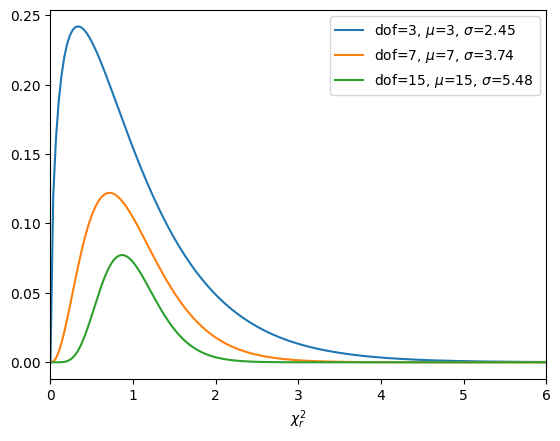

In [63]:
xx = np.linspace(0.0, 100.0, 1000)
plt.figure()
for dof in [3, 7, 15]:
    chi_dist = st.chi2(dof)
    plt.plot(xx / dof, chi_dist.pdf(xx), "-", label=f"dof={dof}, $\mu$={chi_dist.mean():.3g}, $\sigma$={chi_dist.std():.3g}")
plt.xlabel("$\chi_r^2$")
plt.xlim(0, 6.0)
plt.legend(loc="upper right")
plt.show()

## So we can get a $p$-value as well...

Since our $\chi^2$ value is expected to follow the correponding distribution for the same degrees of freedome, we can use the distribution to get a $p$-value. For example, what is the area of the values more extreme than the one we measured?

When comparing different models, we don't have to do this computation. The best model is the one with the reduced $\chi^2$ value closer to 1. 

However, notice that for small d.o.f. the distribution is not symmetric... the best comparison is by finding which model's $\chi^2$ is most probable.

In [64]:
def chi_square(x_data, y_data, model_dist, amplitude, location, width, error_scale):
    y_pred = make_data(x_data, model_dist=model_dist, amplitude=amplitude, location=location, width=width)
    residuals = y_data - y_pred
    return np.sum((residuals / error_scale)**2.0)

chi2_1 = chi_square(x_data, y_data, st.cauchy, amplitude=1.0, location=0.5, width=0.1, error_scale=0.1)
chi2_2 = chi_square(x_data, y_data, st.norm, amplitude=1.0, location=0.5, width=0.1, error_scale=0.1)

reduced_chi2_1 = chi2_1 / len(x_data)
reduced_chi2_2 = chi2_2 / len(x_data)

print("Standard chi-square (Cauchy)   :", chi2_1)
print("Standard chi-square (Gaussian) :", chi2_2)
print()
print("Reduced chi-square (Cauchy)    :", reduced_chi2_1)
print("Reduced chi-square (Gaussian)  :", reduced_chi2_2)

chi2_dist = st.chi2(len(x_data))
print()
print("Ratio of probabilities of chi-sq.:", chi2_dist.pdf(chi2_1) / chi2_dist.pdf(chi2_2))


Standard chi-square (Cauchy)   : 20.252665204006913
Standard chi-square (Gaussian) : 32.38434466198904

Reduced chi-square (Cauchy)    : 0.8101066081602766
Reduced chi-square (Gaussian)  : 1.2953737864795616

Ratio of probabilities of chi-sq.: 1.9500782251393438


## Akaike Information Criterion

When the model describes our system, then the residuals will be essentially a random noise. Nothing can be extracted out of the residuals, except for their "scale". E.g.,:

* when we fit polynomial to our data and the residuals have "structure", we suspect we need either a different functional form, or additional degrees for the polynomial.
* when we subtract starlight in astronomical images (source detection, masking the sources, etc.), sometimes we see residuals or stars that haven't been removed and redo the process with different parameters.

A good model reduces the information we can extract from a system, or... it maximizes its entropy! The AIC is the application of the Second Law of Thermodynamics on statistics using information theory (cf. Shannon's information entropy).

In [65]:
AIC_1 = 2 * 0 - 2 * loglike1
AIC_2 = 2 * 0 - 2 * loglike2
print(AIC_1, AIC_2)

20.252665204006913 32.38434466198904


# What if we don't know one (or more) of the parameters of the models?

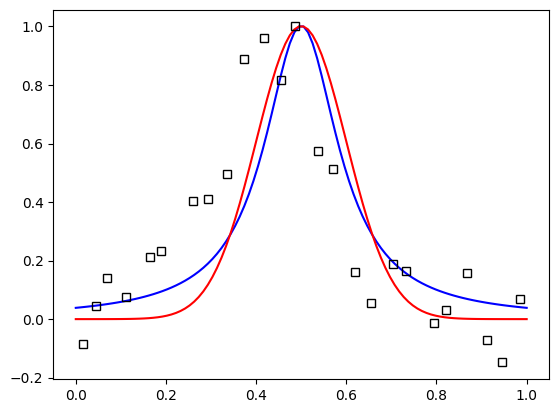

In [67]:
np.random.seed(2023)

x_plot = np.linspace(0, 1, 100)
y1_plot = make_data(x_plot, st.cauchy, amplitude=1.0, location=0.5, width=0.1)
y2_plot = make_data(x_plot, st.norm, amplitude=1.0, location=0.5, width=0.1)

model_distributions = [st.cauchy, st.norm]

n_data = 25
true_location = np.random.uniform(0.3, 0.7)
true_model_distribution = model_distributions[31337 % 17 % 2]
x_data = np.linspace(0.0, 1.0, n_data) + np.random.uniform(-0.5/n_data, 0.5/n_data, size=n_data)
y_data = make_data(x_data, true_model_distribution, amplitude=1.0, location=true_location, width=0.1, error_scale=0.1)
y_data /= y_data.max()
y_data


plt.figure()
plt.plot(x_plot, y1_plot / y1_plot.max(), "b-")
plt.plot(x_plot, y2_plot / y2_plot.max(), "r-")
plt.plot(x_data, y_data, "ks", mfc="none")
plt.show()

# We could fit the models, and compare the likelihoods. AIC and BIC as well...

In [68]:
def func_to_minimize(location, model_dist):
    return -log_likelihood(x_data=x_data, y_data=y_data, model_dist=model_dist, amplitude=1.0, location=location, width=0.1, error_scale=0.1)

# log_likelihood()

minimization_result_1 = minimize(func_to_minimize,  x0=0.5, method="SLSQP", bounds=[[0.0, 1.0]], tol=1.0e-12, args=(st.cauchy))
minimization_result_2 = minimize(func_to_minimize,  x0=0.5, method="SLSQP", bounds=[[0.0, 1.0]], tol=1.0e-12, args=(st.norm))
location_1 = minimization_result_1.x[0]
location_2 = minimization_result_2.x[0]

print("Locations:", location_1, "and", location_2)

loglike1 = log_likelihood(x_data=x_data, y_data=y_data, model_dist=st.cauchy, amplitude=1.0, location=location_1, width=0.1, error_scale=0.1)
loglike2 = log_likelihood(x_data=x_data, y_data=y_data, model_dist=st.norm, amplitude=1.0, location=location_2, width=0.1, error_scale=0.1)

print(loglike1, loglike2)

AIC_1 = 2 * 1 - 2 * loglike1
AIC_2 = 2 * 1 - 2 * loglike2
BIC_1 = 2 * 1 * np.log(n_data) - 2 * loglike1
BIC_2 = 2 * 1 * np.log(n_data) - 2 * loglike2
print("AIC:", AIC_1, AIC_2)
print("BIC:", BIC_1, BIC_2)
print("BF:", np.exp(loglike1 - loglike2))

Locations: 0.4333231940261898 and 0.43373533493726685
-14.551884779262599 -15.998853483739014
AIC: 31.103769558525197 33.997706967478024
BIC: 35.5415212082616 38.43545861721443
BF: 4.25021132179896


## Do you see any problem with fitting before comparing the models?
### TODO: some of these will be moved above since I added new blocks

* Extra trouble: fitting a model is another process that has its own caveats and peculiarities
* If one of the models is flexible enough (e.g., an n-degree polynomial) it would fit the data better due to its flexibility, rather than its representability of real observations.
* Any inference from the model comparison is conditional to the fitting results

In [69]:
from scipy.integrate import quad

def likelihood_uknown_location(x_data, y_data, model_dist, amplitude, width, error_scale):
    def func(loc):
        return np.exp(log_likelihood(x_data=x_data, y_data=y_data, model_dist=model_dist, amplitude=amplitude, location=loc, width=width, error_scale=error_scale))
    
    return quad(func, 0.0, 1.0)[0]

like1_margin = likelihood_uknown_location(x_data, y_data, model_dist=st.cauchy, amplitude=1.0, width=0.1, error_scale=0.1)
like2_margin = likelihood_uknown_location(x_data, y_data, model_dist=st.norm, amplitude=1.0, width=0.1, error_scale=0.1)
print(like1_margin / like2_margin)

5.29286841310491


## ...on the 1/2 or 2 factor appearing all over the hypothesis testing/model comparison statistics

The $1/2$ or $2$ factors appearing in the error estimation when MLEing, in the chi-square test statistic, the log-likelihood of the Guassian-error model are not coincidental! All this is coming from the Guassian distribution - either as the distribution of residuals or an approximation of the shape of a likelihood function! All the formulae in which it appears are effectively assuming some distribution of the data, or a large data size that makes things "bell-curved"! This is often a valid assumption (or approximation) but in reality there are many reasons were readily-available statistical tools would "bias" our analysis. If we have
* few data points
* non-Gaussian uncertainties
* strong priors
* complex non-linear model
* correlations/dependencies in the data (and/or their uncertainties)

it is **preferable to do the analysis from scratch**: (i) likelihood, (ii) priors, (iii) posterior, and finally (iv) parameter estimation/hypothesis testing/model comparison/etc.

# References

[1] D. S. Sivia, J. Skilling (2006). Data Analysis: A Bayesian Tutorial. 2nd Edition. Oxford University Press.